<a href="https://colab.research.google.com/github/Chevron9/iannwtf/blob/Roho6/6/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

50000
10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


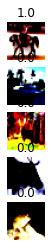

In [3]:
#loads the dataset and splits into test and training data
train_dataset = tfds.load('Cifar10', split="train[:100%]", as_supervised=True)
test_dataset = tfds.load('Cifar10', split="test[:100%]", as_supervised=True)

#normalize the images and make the labels a one hot vector
train_dataset = train_dataset.map(lambda x,y:((tf.image.per_image_standardization(
    tf.cast(x, tf.float32))), (tf.reshape(tf.one_hot(y, 10), (-1,)))))
test_dataset = test_dataset.map(lambda x,y:((tf.image.per_image_standardization(
     tf.cast(x, tf.float32))), (tf.reshape(tf.one_hot(y, 10), (-1,)))))


#creats numpy array to print 
train_numpy= tfds.as_numpy(train_dataset)
test_numpy = tfds.as_numpy(test_dataset)
print(len(train_dataset))
print(len(test_dataset))
#looks if the format is still correct
for i in train_numpy:
  print((type(i[0])))
  break
for i in test_numpy:
  print((type(i[0])))
  break

#shows some images 
fig, ax = plt.subplots(5,1)
x = 0
for j in train_numpy:

  # Readout an image and the corresponding label.
  img = j[0]
  lbl = j[1]

  ax[x].imshow(img)
  ax[x].set_title(lbl[7])
  ax[x].axis("off")

  x += 1

  if x==5:
    break

In [4]:
#shuffel, prefetch and batch the datasets
train_dataset = train_dataset.batch(64).shuffle(buffer_size=64).prefetch(64)
test_dataset = test_dataset.batch(64).shuffle(buffer_size=64).prefetch(64)

In [13]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

#Residualblock class gives you a residual block of alternating convolutional and batch normalization layers
class ResidualBlock(Layer):

  def __init__(self, input_shape):

    super(ResidualBlock, self).__init__()


    self.relu = tf.keras.activations.relu

    self.conv_layer_1= tf.keras.layers.Conv2D(filters= 32, kernel_size= 1,
                                                    strides=(1, 1), padding='same',
                                                    input_shape = input_shape,
                                                    kernel_regularizer=tf.keras.regularizers.L2(0.01))
        
    self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()

    self.conv_layer_2= tf.keras.layers.Conv2D(filters = 32, kernel_size= 3,
                                                    strides=(1, 1), padding='same',
                                                    kernel_regularizer=tf.keras.regularizers.L2(0.01))
    
    self.batch_normalization_layer_2 = tf.keras.layers.BatchNormalization()

    self.conv_layer_3= tf.keras.layers.Conv2D(filters= 32, kernel_size= 1,
                                                    strides=(1, 1), padding='same',
                                                    kernel_regularizer=tf.keras.regularizers.L2(0.01))
    
    self.batch_normalization_layer_3 = tf.keras.layers.BatchNormalization()

  def call(self, x, training = True):
    input = x
    x = self.conv_layer_1(x)
    x = self.batch_normalization_layer_1(x, training)
    x = self.relu(x)

    x = self.conv_layer_2(x)
    x = self.batch_normalization_layer_2(x, training)
    x = self.relu(x)

    x = self.conv_layer_3(x)
    x = self.batch_normalization_layer_3(x, training)
    x = self.relu(x)

    
    return tf.add(x, input)



In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# gives you a residual network 
class ResNet(Model): 
    
    def __init__(self):
        super(ResNet, self).__init__()
        # Define the three layers.

        depth = 1
      
        self.convolutional_layer1 = tf.keras.layers.Conv2D(filters= 32, kernel_size= 3,
                                                  strides=(1, 1), padding='same',
                                                  input_shape = (64,32,32,3),
         
                                                 kernel_regularizer=tf.keras.regularizers.L2(0.01), activation = tf.keras.activations.relu)
        
        self.residual_blocks = [ResidualBlock((64,32,32,32)) for i in range(depth)]

        self.global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, x, training = True):
        # Define the forward step.
        x = self.convolutional_layer1(x)
        for i in self.residual_blocks:
          x = i(x)
       
        x = self.global_pooling_layer(x)
        x = self.output_layer(x)
        return x

In [15]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
#is a transitional layer for a dense network
class TransitionalLayer(Layer):

  def __init__(self, input_shape):

    super(TransitionalLayer, self).__init__()


  

    self.conv_layer_1= tf.keras.layers.Conv2D(filters= input_shape[-1]/2, kernel_size= 1,
                                                    strides=(1, 1), padding='same',
                                                    input_shape = input_shape,
                                                    kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                              )

    self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()

    self.relu = tf.keras.activations.relu

    self.pooling = tf.keras.layers.AveragePooling2D(pool_size=(1,1))
      

    
    

  def call(self, x, training = True):
    x = self.conv_layer_1(x)
    x = self.batch_normalization_layer_1(x)
    x = self.relu(x)
    x = self.pooling(x)
    
    return x



In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
# block of one convolutional layer and batch normalization 
class Block(Layer):
  def __init__(self, input_shape):
    super(Block, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters= input_shape[-1], kernel_size= 3,
                                                    strides=(1, 1), padding='same',
                                                    input_shape = input_shape,
                                                    kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                            )
    self.norm = tf.keras.layers.BatchNormalization()

    
  def call(self, x, training = True):
    input = x
    x = self.conv(x)
    x = self.norm(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.concatenate([input, x], axis=-1)
    return x

In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
# gives a whole dense Block
class DenseBlock(Layer):
  
  def __init__(self, input_shape, depth = 3):
    super(DenseBlock, self).__init__()
    self.layers = []
    for i in range(depth):
      self.layers.append(Block(input_shape))
    
  def call(self, x, training = True):
    
    for i in self.layers:
      x = i(x)
      
    return x

  

In [18]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
#Predefined dense network
class DenseNet(Model): 
    
    def __init__(self):
        super(DenseNet, self).__init__()
        # Define the three layers.
        alterations = 1
        self.convolutional_layer1 = tf.keras.layers.Conv2D(filters= 32, kernel_size= 3,
                                                  strides=(1, 1), padding='same',
                                                  input_shape = (64,32,32,3),
                                                  kernel_regularizer=tf.keras.regularizers.L2(0.01), activation = tf.keras.activations.relu)
        

        self.list_of_alterations =[]
        for i in range(alterations):
          self.list_of_alterations.append(DenseBlock((64,32,32,32)))

          self.list_of_alterations.append(TransitionalLayer((64,32,32,32)))

        self.global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, x, training = True):
        # Define the forward step.
        x = self.convolutional_layer1(x)
        x = self.dense_layer(x, training)
        x = self.global_pooling_layer(x)
        x = self.output_layer(x)
        return x

In [19]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training = False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 5
learning_rate = 0.00006
running_average_factor = 0.95

# Initialize the model.
model = ResNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

#We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Visualize accuracy and loss for training and test data. 
    # One plot training and test loss.
    # One plot training and test accuracy.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()